## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

Similarly as done for classification, the performances of different regression techniques for characterizing users by their voices are assessed in this notebook.

I am addressing the prediction of each of the 34 interpersonal speaker [characteristics](https://github.com/laufergall/Subjective_Speaker_Characteristics) (continuous numeric labels of the [NSC corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus)). These characteristics are: 

'non_likable', 'secure', 'attractive', 'unsympathetic', 'indecisive', 'unobtrusive', 'distant', 'bored', 'emotional', 'not_irritated', 'active', 'pleasant', 'characterless', 'sociable', 'relaxed', 'affectionate', 'dominant', 'unaffected', 'hearty', 'old', 'personal', 'calm', 'incompetent', 'ugly', 'friendly', 'masculine', 'submissive', 'indifferent', 'interesting', 'cynical', 'artificial', 'intelligent', 'childish', 'modest'.

I will consider the common RMSE (root mean squared error) and the more robust to outliers MAPE (median absolute percentage error) as the metrics for success:

\begin{equation}
RMSE = \sqrt{\frac{\sum_i(y_i-\hat{y}_i)^2}{n}}  
\end{equation}

\begin{equation}
MAPE = median(\left | \frac{y_i-\hat{y}_i}{y_i} \right |)
\end{equation}

where $y_i$ and $\hat{y_i}$ are the observed and the predicted values for the $i^{th}$ data point.


In [1]:
import io
import requests
import time # for timestamps

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp after tuner

from reg_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Speaker characteristics 

The files "SC_ratings_medians.csv" and "SC_ratings_medians.csv" have been generated in the ..\data folder.

We consider the same train/test partition of speakers as done for the WAAT classification task.

In [3]:
# load scores (averaged across listeners)

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/"

url = path + "ratings_SC_means.csv"
s = requests.get(url).content
ratings =pd.read_csv(io.StringIO(s.decode('utf-8')))

ratings.head()

,speaker_ID,speaker_gender,non_likable,secure,attractive,unsympathetic,indecisive,unobtrusive,distant,bored,...,friendly,masculine,submissive,indifferent,interesting,cynical,artificial,intelligent,childish,modest
0,1,female,36.571429,65.214286,59.785714,37.357143,33.714286,66.857143,35.642857,35.642857,...,75.428571,20.285714,59.000000,34.571429,60.571429,43.071429,35.785714,65.285714,46.857143,61.071429
1,2,female,66.666667,57.200000,39.333333,54.066667,33.066667,57.266667,56.466667,55.733333,...,55.600000,18.333333,55.133333,58.733333,38.533333,51.533333,63.200000,51.133333,33.533333,60.266667
2,3,female,45.812500,72.562500,47.125000,30.937500,27.937500,46.250000,38.625000,33.437500,...,64.125000,19.937500,46.437500,41.562500,55.562500,50.250000,40.687500,60.250000,14.437500,54.812500
3,4,male,40.071429,59.857143,44.571429,54.428571,35.071429,52.285714,48.571429,49.785714,...,51.428571,75.785714,47.071429,51.357143,49.142857,55.857143,38.071429,55.785714,40.500000,46.928571
4,5,male,42.117647,60.529412,53.823529,50.764706,35.705882,59.764706,49.764706,42.647059,...,54.176471,80.764706,47.823529,53.235294,57.352941,47.705882,35.823529,62.823529,29.294118,49.823529


In [4]:
# save names of speaker characteristics (questionnaire items)
sc_names = list(ratings.drop(['speaker_ID','speaker_gender'], axis=1))

myfile = open(r'.\data_while_tuning\sc_names.csv', 'w')
for item in sc_names:
    myfile.write("%r\n" % item)

In [5]:
# train/test partitions

# read partitions from multioutput multiclass classification
# (stratified taking into account speaker gender)

url = path + "classes_train.csv"
s = requests.get(url).content
classes_train =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "classes_test.csv"
s = requests.get(url).content
classes_test =pd.read_csv(io.StringIO(s.decode('utf-8')))

# partitions of ratings for regression
ratings = ratings.rename(index=str, columns={'speaker_ID': 'spkID'})
ratings_train = ratings[ratings['spkID'].isin(classes_train['spkID'])] # shape (225, 36)
ratings_test = ratings[ratings['spkID'].isin(classes_test['spkID'])] # shape (75, 36)

## Speech features

Same features as for classification (of clean speech).


In [6]:
path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

# extract speaker ID from speech file name
feats['spkID'] = feats['name'].str.slice(2, 5).astype('int')

# appending multilabels to features
feats_ratings_train = pd.merge(feats, ratings_train) # shape (2700, 125)
feats_ratings_test = pd.merge(feats, ratings_test) # shape (891, 125)

# save to csv
feats_ratings_train.to_csv(r'.\data_while_tuning\feats_ratings_train.csv', index=False)
feats_ratings_test.to_csv(r'.\data_while_tuning\feats_ratings_test.csv', index=False)

# save feature names
dropcolumns = ['name','spkID','speaker_gender'] + sc_names
feats_names = list(feats_ratings_train.drop(dropcolumns, axis=1))

myfile = open(r'.\data_while_tuning\feats_names.csv', 'w')
for item in feats_names:
    myfile.write("%r\n" % item)

In [7]:
# Standardize speech features  

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_ratings_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_ratings_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_ratings_test.drop(dropcolumns, axis=1)) 

## Model tuning with feature selection

As done for classification, I perform nested hyperparameter tuning with feature selection.

* Feature selection: SelectKBest(f_regression), tuning k
* RandomizedSearchCV on hyperparameters with uniform distribution, instead of grid search
* metric: neg_mean_squared_error


In [8]:
# select a trait
# perform this on a loop later
target_trait = sc_names[0]

In [ ]:
X = feats_s_train # (2700, 88)
y = feats_ratings_train[target_trait].as_matrix() # (2700,)

Xt = feats_s_test # (891, 88)
yt = feats_ratings_test[target_trait].as_matrix() # (891,)

# split train data into 80% and 20% subsets - with balance in gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_ratings_train['speaker_gender'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])


In [10]:
# save splits

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X_' + target_trait + '.npy', X)
np.save(r'.\data_while_tuning\y_' + target_trait + '.npy', y)
np.save(r'.\data_while_tuning\Xt_' + target_trait + '.npy', Xt)
np.save(r'.\data_while_tuning\yt_' + target_trait + '.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX_' + target_trait + '.npy', AX)
np.save(r'.\data_while_tuning\BX_' + target_trait + '.npy', BX)
np.save(r'.\data_while_tuning\Ay_' + target_trait + '.npy', Ay)
np.save(r'.\data_while_tuning\By_' + target_trait + '.npy', By)

In [3]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

### Calling hp_tuner() for each target and each regressor

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [3]:
# original features and ratings

feats_ratings_train = pd.read_csv(r'.\data_while_tuning\feats_ratings_train.csv')

feats_ratings_test = pd.read_csv(r'.\data_while_tuning\feats_ratings_test.csv')

feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header = None)
feats_names = feats_names.values.tolist()

sc_names = pd.read_csv(r'.\data_while_tuning\sc_names.csv', header = None)
sc_names = sc_names.values.tolist()


In [4]:
# select a trait
# perform this on a loop later
target_trait = sc_names[0][0].strip('"\'')

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_' + target_trait + '.npy')
y = np.load(r'.\data_while_tuning\y_' + target_trait + '.npy')
Xt = np.load(r'.\data_while_tuning\Xt_' + target_trait + '.npy')
yt = np.load(r'.\data_while_tuning\yt_' + target_trait + '.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX_' + target_trait + '.npy')
BX = np.load(r'.\data_while_tuning\BX_' + target_trait + '.npy')
Ay = np.load(r'.\data_while_tuning\Ay_' + target_trait + '.npy')
By = np.load(r'.\data_while_tuning\By_' + target_trait + '.npy')

In [5]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning(target_trait)

Call this after each experiment **to recover later**: 

In [16]:
# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Linear regression

*class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)*

Check performance with linear regression just as baseline.

(Need to improve this by removing feature collinearity first)

In [7]:
from sklearn.linear_model import LinearRegression

"""
Linear Regression
"""
def get_LinearRegression2tune():

    model = LinearRegression()
    hp = dict()
    return 'LinearRegression', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_LinearRegression2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           'grid')

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'LinearRegression' -> Best cross-val score on A set: -78.224839 using {'selecter__k': 87}
'LinearRegression' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_percentile80.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sm

#### ElasticNet Regression

*class sklearn.linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection=’cyclic’)*

Combines the properties of both Ridge Regression and LASSO regression.

In [8]:
from sklearn.linear_model import ElasticNet

"""
ElasticNet Regression
"""
def get_ElasticNet2tune():

    model = ElasticNet()
    hp = dict()
    return 'ElasticNet', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_ElasticNet2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           'grid')

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'ElasticNet' -> Best cross-val score on A set: -91.034971 using {'selecter__k': 68}
'ElasticNet' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sma3_amean'"], ["'mfcc1_sma3_amean'"], ["'mfcc1_sma3_stddevNorm'"], ["'mfcc3_sma3_amean'"], ["'mfcc3_sma3_stddevNorm'"], ["'mfcc4_sma3_amean'"], ["'mfcc4_sma3_stddevNorm'"], [

#### K Nearest Neighbors

*class sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)*

Tuning number of neighbors.

In [9]:
from sklearn.neighbors import KNeighborsRegressor

"""
K Nearest Neighbors
"""
def get_KNeighborsRegressor2tune():

    model = KNeighborsRegressor()
    hp = dict(
        regressor__n_neighbors = list(range(1,40)),
        regressor__weights = ['uniform','distance'],
        regressor__algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    )
    return 'KNeighborsRegressor', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KNeighborsRegressor2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           'random')

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsRegressor' -> Best cross-val score on A set: -49.896760 using {'selecter__k': 61, 'regressor__weights': 'distance', 'regressor__n_neighbors': 4, 'regressor__algorithm': 'brute'}
'KNeighborsRegressor' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sma3_amean'"], ["'mfcc1_sma3_stddevNorm'"], ["'mfcc3_sma3_amean'"], ["'mfcc3_sma3_stddevNorm'"], ["'mfcc4_sma3_ame

  regressor__algorithm regressor__n_neighbors regressor__weights selecter__k
0              kd_tree                      7           distance          81
1            ball_tree                     16            uniform          23
2                 auto                     10           distance          56
3                 auto                     35           distance          73
4                brute                     10            uniform          74


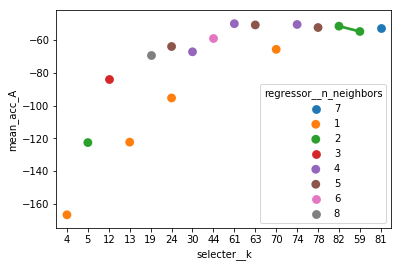

In [12]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
params_df = params_df.loc[params_df['regressor__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__n_neighbors', data=sgrid.join(params_df)) 

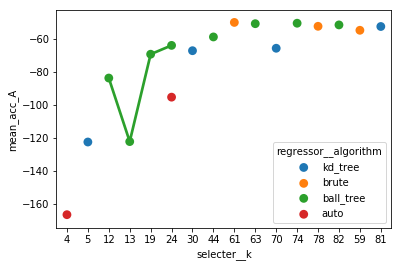

In [13]:
# plot acc vs. params
params_df = params_df.loc[params_df['regressor__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__algorithm', data=sgrid.join(params_df)) 

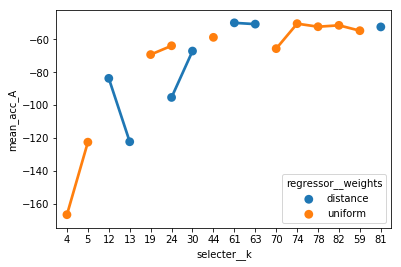

In [14]:
# plot acc vs. params
params_df = params_df.loc[params_df['regressor__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__weights', data=sgrid.join(params_df)) 

From this quick random search, we can see that this is contributing to the error to be lower:

* regressor__algorithm: 'brute' and 'ball_tree' seem to be fine with k>44. Let us stick to 'brute'
* regressor__n_neighbors: 4 or 5 neighbors
* regressor__weights: 'distance' seems to be fine with k>44
* selecter__k: k >= 44

In [45]:

# Fine-tuning KNeighborsRegressor with gridsearch

def get_KNeighborsRegressor2finetune():

    model = KNeighborsRegressor()
    hp = dict(
        regressor__n_neighbors = list(range(3,7)),
        regressor__weights = ['distance'],
        regressor__algorithm = ['brute']
    )
    return 'KNeighborsRegressor', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KNeighborsRegressor2finetune], 
                           target_trait,
                           feats_names,
                           np.arange(44, AX.shape[1]), 
                           'grid')

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsRegressor' -> Best cross-val score on A set: -47.882521 using {'regressor__algorithm': 'brute', 'regressor__n_neighbors': 3, 'regressor__weights': 'distance', 'selecter__k': 84}
'KNeighborsRegressor' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_percentile80.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlop

  regressor__algorithm regressor__n_neighbors regressor__weights selecter__k  \
0                brute                      3           distance          44   
1                brute                      3           distance          45   
2                brute                      3           distance          46   
3                brute                      3           distance          47   
4                brute                      3           distance          48   

       reg_params  
0  brutedistance3  
1  brutedistance3  
2  brutedistance3  
3  brutedistance3  
4  brutedistance3  


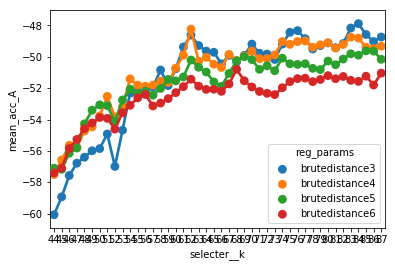

In [46]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
params_df['reg_params'] = params_df['regressor__algorithm'].values + params_df['regressor__weights'].values + params_df['regressor__n_neighbors'].values.astype(str)
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='reg_params', data=sgrid.join(params_df)) 

After fine-tuning, k=3 outperforms k=4. Root mean_squared_error on B set: 6.46 -> this is similar performance as with random search

#### Support Vector Machines

*class sklearn.svm.SVR(kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)*

Hyperparameter tuning of SVR with different kernels:

I create a different function for each kernel. Tuning C (Penalty of the error term), degree (for 'poly' only), and gamma. No feature selection (k = [88]), since SVM should work better with higher number of features.

In [6]:
from sklearn.svm import SVR

"""
Support Vector Machines with linear kernel
"""
def get_SVRlinear2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(-5,2,num=8),
        regressor__kernel = ['linear']
    )
    return 'SVRlinear', model, hp

# tune with linear kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRlinear2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid'
                           n_iter=30 # ignored
                          )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'SVRlinear' -> Best cross-val score on A set: -82.511094 using {'regressor__C': 100.0, 'regressor__kernel': 'linear', 'selecter__k': 88}
'SVRlinear' -> root mean_squared_error on B set: 9.264138



Support Vector Machines with rbf kernel. (hp ranges based on a quick random search)

In [14]:
from sklearn.svm import SVR

"""
Support Vector Machines with rbf kernel
"""
def get_SVRrbf2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(-3,1,num=5),
        regressor__kernel = ['rbf'], 
        regressor__gamma = np.logspace(-3,-1,num=3)
    )
    return 'SVRrbf', model, hp


# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRrbf2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid',
                           n_iter=30 # ignored
                          )


'SVRrbf' -> Best cross-val score on A set: -59.066775 using {'regressor__C': 10.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf', 'selecter__k': 88}
'SVRrbf' -> root mean_squared_error on B set: 7.052087



  regressor__C regressor__gamma regressor__kernel selecter__k
0        0.001            0.001               rbf          88
1        0.001             0.01               rbf          88
2        0.001              0.1               rbf          88
3         0.01            0.001               rbf          88
4         0.01             0.01               rbf          88


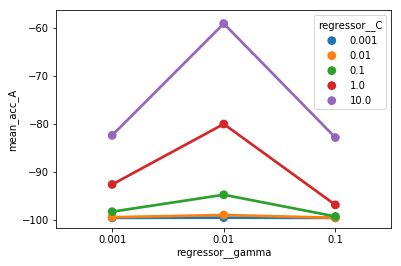

In [15]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRrbf_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__gamma', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 

The value gamma = 0.01 and higher complexity seems promising. Let us perform another gridsearch.

In [16]:
from sklearn.svm import SVR

"""
Support Vector Machines with rbf kernel
"""
def get_SVRrbf2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(1,4,num=5),
        regressor__kernel = ['rbf'], 
        regressor__gamma = [0.01]
    )
    return 'SVRrbf', model, hp


# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRrbf2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid',
                           n_iter=30 # ignored
                          )

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

'SVRrbf' -> Best cross-val score on A set: -46.687707 using {'regressor__C': 316.22776601683796, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf', 'selecter__k': 88}
'SVRrbf' -> root mean_squared_error on B set: 6.092025



  regressor__C regressor__gamma regressor__kernel selecter__k
0           10             0.01               rbf          88
1      56.2341             0.01               rbf          88
2      316.228             0.01               rbf          88
3      1778.28             0.01               rbf          88
4        10000             0.01               rbf          88


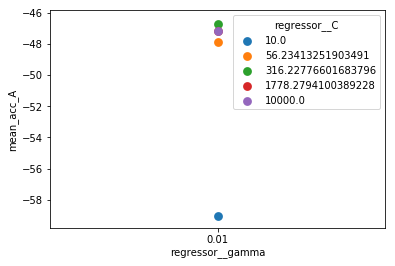

In [17]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRrbf_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__gamma', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 

TODO: go on with other regressors. Tune in loop for all items 

In [ ]:
from sklearn.svm import SVR

"""
Support Vector Machines with sigmoid kernel
"""
def get_SVRsigmoid2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(-5,3,num=9),
        regressor__kernel = ['sigmoid'],
        regressor__gamma = np.logspace(-5,5,num=11)
    )
    return 'SVRsigmoid', model, hp

# tune with sigmoid kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRsigmoid2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'random')

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# neigh = KNeighborsRegressor(n_neighbors=11, weights = 'distance')
# neigh.fit(X, y) 

 
# y_pred = neigh.predict(Xt) 


# # root mean squared error
# myrmse = np.sqrt(mean_squared_error(yt, y_pred))
# print(myrmse)

# # median absolute percentage error 
# mymape = mape(yt, y_pred)
# print(mymape)

# # coefficient of determination R^2
# R2 = r2_score(yt, y_pred)
# print(R2)

# score = neigh.score(Xt, yt)
# print(score) # same as R2

In [ ]:
# def mape(targets, predictions):
#     return np.median(abs((targets - predictions)/targets))